Processing with block size: 16
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0689 seconds

Processing with block size: 32
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0677 seconds

Processing with block size: 64
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0668 seconds

Processing with block size: 128
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0676 seconds

Processing with block size: 256
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0678 seconds

Processing with block size: 512
Processing images:
Image width: 5760
Image height: 3840
===================GPU PROCESSING===================
GPU Time: 0.0668 seconds



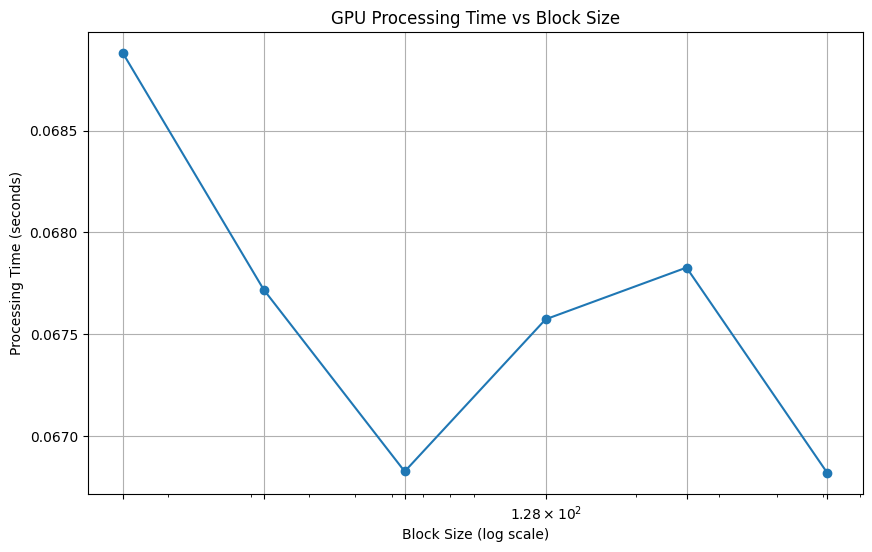

In [3]:
import os
import time
import numpy as np
from numba import cuda
from PIL import Image  # Import PIL for saving as JPEG
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Function to process the image and return GPU processing time
def process_image(image_path, block_size):
    # Get image
    image = Image.open(image_path).convert('RGB')  # Read the image properly using PIL
    print(f"Processing images:")
    print(f"Image width:", image.width)
    print(f"Image height:", image.height)
    pixels = np.array(image)
    pixel_count = image.width * image.height  # Total number of pixels
    pixels = pixels.reshape(-1, 3)  # Reshape to (pixel_count, 3) for RGB

    ### RGB to Gray: GPU
    print("===================GPU PROCESSING===================")
    start_gpu = time.time()
    
    ## 1. CPU feeds data to GPU: Allocate memory
    dev_input = cuda.to_device(pixels)  # Must be (Nx3) matrix
    dev_output = cuda.device_array((pixel_count, 3), dtype=np.uint8)  # Adjust output to store RGB values

    ## 2. CPU asks GPU to process
    grid_size = (pixel_count + block_size - 1) // block_size  # Calculate grid size

    ## 3. GPU processing with Kernel:
    @cuda.jit
    def grayscale_kernel(src, dst):
        # Calculate the index for each thread
        idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
        if idx < src.shape[0]:
            # Compute grayscale value using average method
            g = (src[idx, 0] + src[idx, 1] + src[idx, 2]) // 3
            dst[idx, 0] = dst[idx, 1] = dst[idx, 2] = g

    grayscale_kernel[grid_size, block_size](dev_input, dev_output)

    # 4. GPU copy results to CPU
    host_output_gpu = dev_output.copy_to_host()
    end_gpu = time.time()

    # Print processing times
    gpu_time = end_gpu - start_gpu
    return gpu_time

# Main code to test different block sizes and plot results
image_path = 'image2.jpg'  # Path to your image
block_sizes = [16, 32, 64, 128, 256, 512]  # Different block sizes to test
processing_times = []

# Measure processing time for each block size
for block_size in block_sizes:
    print(f"Processing with block size: {block_size}")
    gpu_time = process_image(image_path, block_size)
    processing_times.append(gpu_time)
    print(f'GPU Time: {gpu_time:.4f} seconds\n')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, processing_times, marker='o')
plt.xscale('log')  # Log scale for better visibility
plt.xlabel('Block Size (log scale)')
plt.ylabel('Processing Time (seconds)')
plt.title('GPU Processing Time vs Block Size')
plt.grid(True)
plt.xticks(block_sizes)
plt.show()